# Data exploration

## Imports

In [74]:
import json
import numpy as np
import requests
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
from functools import lru_cache
from datetime import timedelta

## Spotify Auth and Token

In [114]:
scope = "user-read-playback-state,user-modify-playback-state"

token = spotipy.util.prompt_for_user_token(
    "eosimias",
    scope=scope,
    client_id=None,
    client_secret=None,
    redirect_uri=None,
    cache_path=None,
    oauth_manager=None,
    show_dialog=False,
)

sp = spotipy.Spotify(auth=token)

## Explore Playlist

In [5]:
playlist_uri = 'spotify:playlist:5mSVi1sqlgIfkwT1P995az'

In [6]:
def get_audio_features_for_playlist(playlist_uri):
    results = sp.playlist_tracks(playlist_uri)
    songs = results["items"]
    tracks = [song["track"]["id"] for song in songs]
    names = [song["track"]["name"] for song in songs]
    return sp.audio_features(tracks=tracks), names

In [7]:
features, names = get_audio_features_for_playlist(playlist_uri)

In [8]:
features[0]

{'danceability': 0.394,
 'energy': 0.242,
 'key': 2,
 'loudness': -14.371,
 'mode': 1,
 'speechiness': 0.0627,
 'acousticness': 0.683,
 'instrumentalness': 0.00113,
 'liveness': 0.0934,
 'valence': 0.333,
 'tempo': 178.908,
 'type': 'audio_features',
 'id': '08HnZYZBZEG76sslHpD7Yc',
 'uri': 'spotify:track:08HnZYZBZEG76sslHpD7Yc',
 'track_href': 'https://api.spotify.com/v1/tracks/08HnZYZBZEG76sslHpD7Yc',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/08HnZYZBZEG76sslHpD7Yc',
 'duration_ms': 212107,
 'time_signature': 3}

In [103]:
def plot_playlist_data(features, names):

    playlist_info = sp.playlist(playlist_uri)

    x = list(range(1, len(features)))
    y0 = [feature["energy"] for feature in features]
    y1 = [feature["danceability"] for feature in features]
    y2 = [feature["valence"] for feature in features]
    y3 = [feature["tempo"] for feature in features]

    # Create traces
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(x=x, y=y0, mode="lines+markers", name="energy"), secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=x, y=y1, mode="lines+markers", name="danceability"),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=x, y=y2, mode="lines+markers", name="valence"), secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=x, y=y3, name="tempo/bpm"), secondary_y=True,
    )

    # Add figure title

    fig.update_layout(
        title_text=f"{playlist_info['name']}"
    )

    # Set y-axes titles
    fig.update_yaxes(title_text="energy/danceability/valence", secondary_y=False)
    fig.update_yaxes(title_text="Tempo in beats per minute", secondary_y=True)

    fig.update_xaxes(tickangle=45, tickfont=dict(size=10))

    fig.update_layout(xaxis=dict(tickmode="linear", tick0=1, dtick=1))
    fig.update_layout(xaxis=dict(tickmode="array", tickvals=x, ticktext=names))
    fig.update_layout(template="simple_white", clickmode="event+select")

    return fig


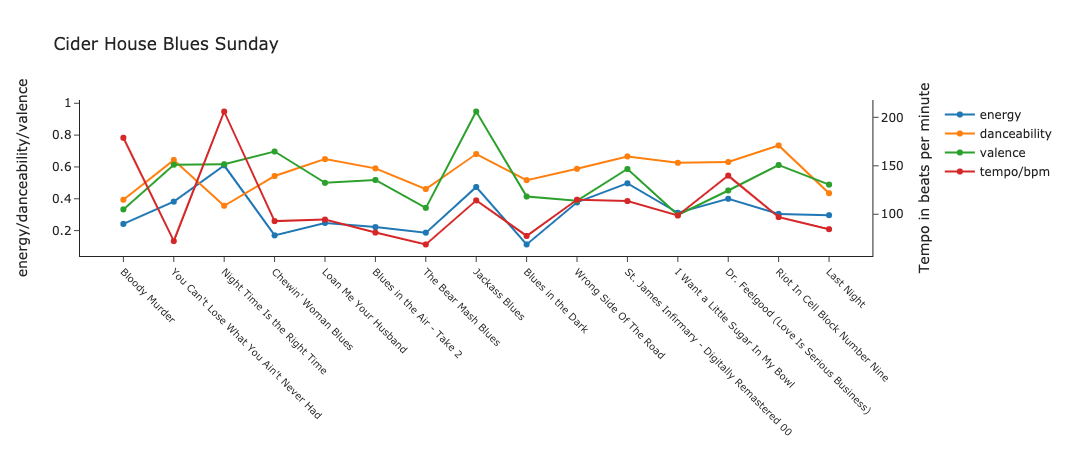

In [104]:
plot_playlist_data(features, names)

In [14]:
playlist_tracks = sp.playlist_tracks(playlist_uri)['items']
song_uris = [track['track']['uri'] for track in playlist_tracks]

In [53]:
@lru_cache()
def get_audio_analysis(song_uri):
    return sp.audio_analysis(song_uri)

In [15]:
audio_analyses = []
for song_uri in song_uris:
    audio_analysis_results = get_audio_analysis(song_uri)
    audio_analyses.append(audio_analysis_results)

In [25]:
durations = [feature['duration_ms'] for feature in features]

In [ ]:
## try and plot loudness/tempo by section across the entire playlist

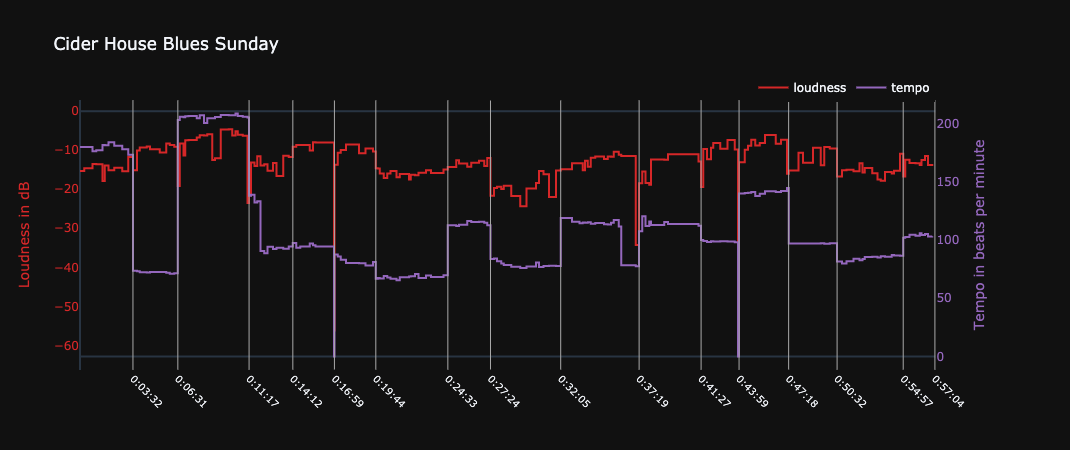

In [111]:
def add_offset_to_array(array, offset):
    return [(element+offset) for element in array]
    
    
def plot_all_sections_of_playlist(playlist_uri):
    playlist_info = sp.playlist(playlist_uri)
    playlist_tracks = sp.playlist_tracks(playlist_uri)['items']
    song_uris = [track['track']['uri'] for track in playlist_tracks]
    
    offset = 0
    song_start_times =[]
    full_x = []
    full_y0 = []
    full_y1 = []
    
    for song in song_uris:
            analysis = get_audio_analysis(song)
            sections = analysis['sections']

            y0 = [section['loudness'] for section in sections]
            y1 = [section['tempo'] for section in sections]

            start_times = [section['start'] for section in sections]
            x = add_offset_to_array(start_times, offset)
            offset = offset + sections[-1]['start'] + sections[-1]['duration']

            full_x += x
            full_y0 += y0
            full_y1 += y1
            song_start_times.append(offset) 
    
    x_text = [str(timedelta(seconds=int(s))) for s in song_start_times]
        
    # Create traces
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    for start_time in song_start_times:
        fig.add_shape(dict(type="line", x0=start_time, y0=min(full_y0)-10, x1=start_time, y1=math.inf, 
                           line=dict(color="darkgrey", width=1)))
        
    fig.add_trace(
        go.Scatter(x=full_x, y=full_y0, mode="lines", name="loudness",line_shape='hv',
                   line = dict(color='#d62728')), secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=full_x, y=full_y1, mode="lines", name="tempo",line_shape='hv',
                   line = dict(color='#9467bd')),secondary_y=True,
    )

    fig.update_layout(
        title_text=f"{playlist_info['name']}"#add name when adding to app.py
    )

    fig.update_layout(yaxis=dict(title="Loudness in dB", titlefont=dict( color="#d62728"), tickfont=dict(color="#d62728")),
                      yaxis2=dict(title="Tempo in beats per minute",titlefont=dict(color="#9467bd"), tickfont=dict(color="#9467bd")))

    fig.update_layout(legend_orientation="h", legend=dict(x=0.74, y=1.1))
    fig.update_layout(xaxis=dict(tickmode="array", tickvals=song_start_times, ticktext=x_text))
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False,yaxis2_showgrid=False )
    fig.update_layout(template="plotly_dark")
    
    return fig.show()

plot_all_sections_of_playlist(playlist_uri)

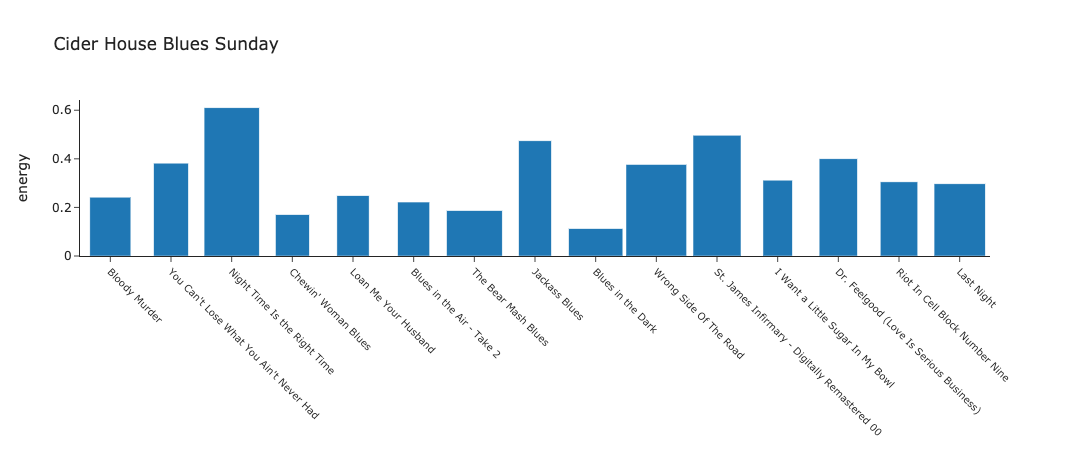

In [126]:
def plot_playlist_data(playlist_uri):

    playlist_info = sp.playlist(playlist_uri)
    
    features, names = get_audio_features_for_playlist(playlist_uri)
    
    durations = [feature['duration_ms'] for feature in features]
    maximum = max(durations)
    durations = [duration/maximum for duration in durations]

    x = list(range(1, len(features)))
    y0 = [feature["energy"] for feature in features]
    y1 = [feature["danceability"] for feature in features]
    y2 = [feature["valence"] for feature in features]
    y3 = [feature["tempo"] for feature in features]

    # Create traces
    fig = go.Figure(data=[go.Bar(x=x, y=y0, width=durations)]) # customize width here
    

    # Add figure title

    fig.update_layout(
        title_text=f"{playlist_info['name']}"
    )

    # Set y-axes titles
    fig.update_yaxes(title_text="energy")

    fig.update_xaxes(tickangle=45, tickfont=dict(size=10))

    fig.update_layout(xaxis=dict(tickmode="linear", tick0=1, dtick=1))
    fig.update_layout(xaxis=dict(tickmode="array", tickvals=x, ticktext=names))
    fig.update_layout(template="simple_white", clickmode="event+select", bargap=0)

    return fig

plot_playlist_data(playlist_uri)

In [116]:
max(durations)

314107

## Explore Genre

In [17]:
# playlist_tracks = sp.playlist_tracks(playlist_uri)['items']

In [21]:
artist_ids = [track['track']['album']['artists'][0]['id'] for track in playlist_tracks]

In [22]:
artists = sp.artists(artist_ids)

In [25]:
song_uris = [result['track']['uri'] for result in results]

In [55]:
artists['artists']

In [23]:
artist_genres = {artist['name']: artist['genres'] for artist in artists['artists']}
